# Pipeline for image size estimation

Imports

In [1]:
# basics
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
# file work
import os
import json
# computer vision
import cv2
import torch
import laser_detection as ld
# models
from segment_anything import sam_model_registry, SamPredictor
from easy_ViTPose import VitInference
from huggingface_hub import hf_hub_download

/cluster/tufts/fuzzywuzzy/jbrand12/condaenv/fzwz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 0: Assign input point to each image

run: 'python3 label.py' to get json of image names and input points (change path to folder in script)

## Step 1: Load image data from json

The below are modifiable variables you can change depending on what dataset you are running

In [2]:
# ALL DATA
json_file = '../data/perfect.json'  # must contain input labels
image_folder = '../data/perfect'
mask_folder = '../data/perfect_masks'  # can be empty to start

# SAMPLE DATA
# json_file = 'sample_data/red_lasers/sample_data.json'  # must contain input labels
# image_folder = 'sample_data/red_lasers/sample_data'
# mask_folder = 'sample_data/red_lasers/sample_data_masks'  # can be empty to start

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [3]:
len(image_data)

72

## Step 2: Run images through SAM to prep for laser detection

### ***only need to run this code once to get masks!!!

Set up SAM

In [4]:
# select checkpoint and model type
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

# define predictor
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# change device if cuda is available
if torch.cuda.is_available():
    sam.to(device='cuda')

predictor = SamPredictor(sam)

In [5]:
def generate_mask(im, input_point):
    input_label = np.array([1])
    predictor.set_image(im)
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    # return best mask
    return masks[np.argmax(scores)]

Iterate through images and get mask

In [6]:
from tqdm import tqdm
# iterate through each entry in the JSON data
for image_name, im_data in tqdm(image_data.items(), desc="SAM"):
    image_path = os.path.join(image_folder, image_name)
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # extract coordinates
    input_point = np.array([im_data['input_point']])
    # Generate the mask
    mask = generate_mask(img, input_point)
    mask = mask.astype(np.uint8)

    # Define the mask filename
    mask_filename = os.path.splitext(image_name)[0] + "_mask.png"
    mask_path = os.path.join(mask_folder, mask_filename)

    # Save the mask
    cv2.imwrite(mask_path, mask)

    # Update the JSON data with the mask filename
    image_data[image_name]['mask'] = mask_filename

SAM: 100%|██████████| 72/72 [00:44<00:00,  1.61it/s]


## Step 3: Run VitPose

In [7]:
# define model parameters
MODEL_SIZE = 'h'
YOLO_SIZE = 'n'
DATASET = 'apt36k'
ext = '.pth'
ext_yolo = '.pt'

# download model_path and yolo_path
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, 
                        f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo
print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

In [8]:
# initialize model
model = VitInference(model_path, yolo_path, MODEL_SIZE, dataset=DATASET)

In [9]:
count = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="ViTPose"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    # get keypoints
    img_arr = np.array(img, dtype=np.uint8)
    keypoints = model.inference(img_arr)

    if keypoints:
        # TODO - handle case with more than one chimp detected
        # store results
        shoulder = (int(keypoints[0][3][1]), int(keypoints[0][3][0]))
        rump = (int(keypoints[0][4][1]), int(keypoints[0][4][0]))
      
        # Update the JSON data with shoulder and rump
        image_data[image_name]['shoulder_rump'] = [shoulder, rump]
    else:
        count += 1
        image_data[image_name]['shoulder_rump'] = None

print(f"vitpose failed for {count} images")

ViTPose: 100%|██████████| 72/72 [00:13<00:00,  5.24it/s]

vitpose failed for 3 images


## Step 4: laser point detection

In [3]:
# Function to compute y from x using the line equation
def compute_y(x, slope, intercept):
    return int(slope * x + intercept)

# Function to create the mask with actual image dimensions
def create_geo_mask(point1, point2, image_height=1728, image_width=2592):
    # Calculate the slope and intercept of the line between the points
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    slope = dy / dx if dx != 0 else None

    # Calculate the perpendicular slopes
    if slope is not None:
        perpendicular_slope = -1 / slope
        # Calculate the intercept for the perpendicular lines
        intercept1 = point1[1] - (perpendicular_slope * point1[0])
        intercept2 = point2[1] - (perpendicular_slope * point2[0])
    else:
        # If the line is vertical, the perpendiculars will be horizontal
        perpendicular_slope = 0
        intercept1 = point1[1]
        intercept2 = point2[1]

    # Create an empty mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)

    # Fill the mask
    for x in range(image_width):
        if slope is not None:
            y_from_point1 = compute_y(x, perpendicular_slope, intercept1)
            y_from_point2 = compute_y(x, perpendicular_slope, intercept2)
        else:
            # If original line is vertical, fill entire column for mask
            y_from_point1, y_from_point2 = 0, image_height - 1

        # Ensure the y values are within image boundaries
        y_from_point1 = np.clip(y_from_point1, 0, image_height - 1)
        y_from_point2 = np.clip(y_from_point2, 0, image_height - 1)

        if y_from_point1 < y_from_point2:
            mask[y_from_point1:y_from_point2, x] = 255
        else:
            mask[y_from_point2:y_from_point1, x] = 255

    return mask

In [4]:
import importlib
importlib.reload(ld)

<module 'laser_detection' from '/cluster/tufts/fuzzywuzzy/jbrand12/fuzzy-wuzzy/laser_detection.py'>

In [ ]:
count = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="Laser Detection"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    source = cv2.imread(image_path)

    # geo mask
    sr = info['shoulder_rump']
    if sr:
        point1, point2 = sr[0], sr[1]
        geo_mask = create_geo_mask(point1, point2, source.shape[0], source.shape[1])
    else:
        geo_mask = np.ones(source.shape[:2], dtype=np.uint8)

    # body mask
    mask_filename = info['mask']
    mask_path = os.path.join(mask_folder, mask_filename)
    body_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

    mask = cv2.bitwise_and(geo_mask, body_mask)
    mask = mask > 0  # need to convert to boolean values

    # adjust accodringly
    points = ld.detect_red_laser_points(source, mask)

    # Update the JSON data with the mask filename
    if len(points) == 2:
        image_data[image_name]['laser_points'] = points
    else:
        count += 1
        image_data[image_name]['laser_points'] = None
        
print(f"Laser Detection failed for {count} images")

Laser Detection:  97%|█████████▋| 70/72 [07:17<00:13,  6.79s/it]

### Step 5: get distances

In [ ]:
measured_df = pd.read_csv('../data/measured.csv')
measured_df = measured_df.dropna(subset=['PhotoID', 'Laser Width', 'BodyLength1'])

Get dictionaries for conversions

In [ ]:
laser_width = dict(zip(measured_df['PhotoID'], measured_df['Laser Width']))
body_length = dict(zip(measured_df['PhotoID'], measured_df['BodyLength1']))
pix_laser = dict(zip(measured_df['PhotoID'], measured_df['PixLaser1']))
pix_length = dict(zip(measured_df['PhotoID'], measured_df['PixLength1']))

In [ ]:
# iterate through each entry in json
predicted_lengths = []
count = 0 # number of images that were able to generate a prediction
fail_ims =[] # store names of images where model failed

# store specific errors
errors = []
laser_errors = []
body_errors = []
for image_name, info in tqdm(image_data.items(), desc="Calculating Final Distances"):
    # distances in pixels
    laser_points = info['laser_points']
    body_points = info['shoulder_rump']

    if laser_points and body_points:
        # calculate pixel distances
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1) # spreadsheet rounds this value to 1
        body_dist = round(math.dist(body_points[0], body_points[1]), 1) # same here
        ratio = laser_dist / body_dist

        # lookup laser width
        photo_id = image_name.split('.')[0]
        laser_in = laser_width[photo_id]
        
        # compare results
        predicted_length = laser_in / ratio
        predicted_lengths.append(predicted_length)
        true_length = body_length[photo_id]
        
        error = round((predicted_length - true_length) / true_length, 3) * 100

        # count number of predictions with less than 10% error
        if abs(error) < 10:
            count += 1

        if abs(error) < 50:
            if abs(error) > 20:
                print(error, image_name)
            errors.append(error)
            # laser error
            true_laser = pix_laser[photo_id]
            laser_error = round((laser_dist - true_laser) / true_laser, 3) * 100
            laser_errors.append(laser_error)

            # body error
            true_body = pix_length[photo_id]
            body_error = round((body_dist - true_body) / true_body, 3)
            body_errors.append(body_error*100)
    else:
        fail_ims.append(image_name)

print(f"{count} / {len(image_data) - len(fail_ims)} images with less than 10 percent error")
print(f"model was unable to generate prediction for {len(fail_ims)} images")

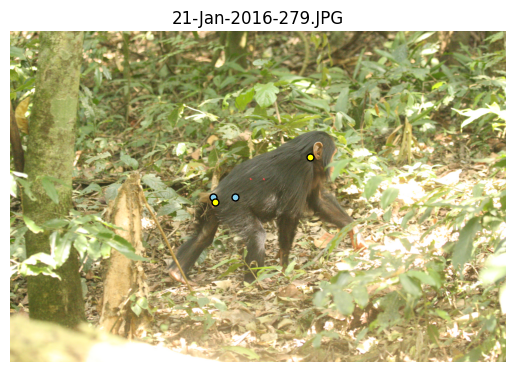

In [77]:
image_path = os.path.join(image_folder, '29-Jan-2016-460.JPG')
# load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

info = image_data['29-Jan-2016-460.JPG']

# extract coordinates
laser_points = np.array(info['laser_points'])
body_points = np.array(info['shoulder_rump'])

# plot image
plt.imshow(img)

draw_dots(laser_points, plt, "skyblue")
draw_dots(body_points, plt, "yellow")
plt.title(f"{image_name}")
plt.axis('off')

plt.show()

### Save final results

In [15]:
# Write the updated JSON data to a file
with open(json_file, 'w') as file:
    json.dump(image_data, file, indent=4)

print(f"Updated data saved to {json_file}")

Updated data saved to ../data/perfect.json


## Insepct Results

In [65]:
len(body_errors)

60

In [66]:
data = {
    'Measurement': ['Final Error', 'Laser Error', 'Body Error'],
    'Mean': [np.mean(errors), np.mean(laser_errors), np.mean(body_errors)],
    'Median': [np.median(errors), np.median(laser_errors), np.median(body_errors)],
    'Std Dev': [np.std(errors), np.std(laser_errors), np.std(body_errors)],
    'Min': [np.min(errors), np.min(laser_errors), np.min(body_errors)],
    'Max': [np.max(errors), np.max(laser_errors), np.max(body_errors)]
}
# Create a DataFrame
results_df = pd.DataFrame(data)

In [67]:
# Print the DataFrame
print(results_df)

   Measurement      Mean  Median   Std Dev   Min   Max
0  Final Error -2.753333   -2.85  7.819537 -39.7  21.7
1  Laser Error  0.445000    0.00  9.194064 -19.9  66.4
2   Body Error -2.850000   -2.45  4.930940 -16.8   7.8


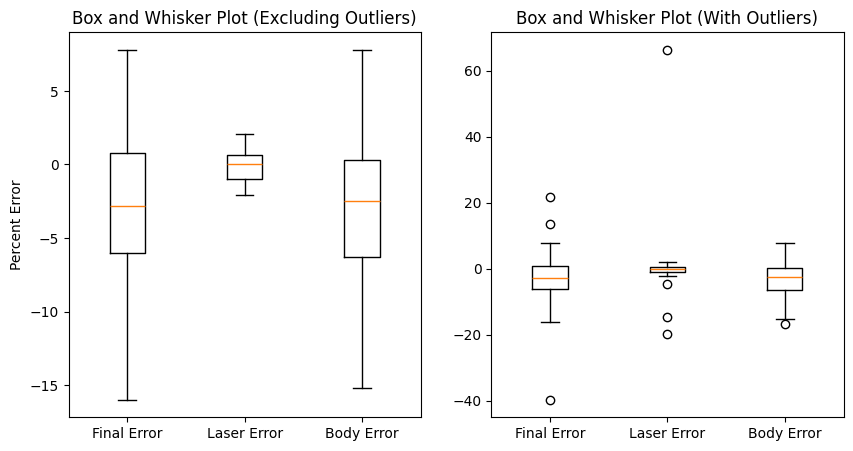

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

data = [errors, laser_errors, body_errors]
axs[0].boxplot(data, showfliers=False)
axs[0].set_ylabel("Percent Error")
axs[0].set_xticks([1, 2, 3], ['Final Error', 'Laser Error', 'Body Error'])
axs[0].set_title('Box and Whisker Plot (Excluding Outliers)')

axs[1].boxplot(data, showfliers=True)
axs[1].set_xticks([1, 2, 3], ['Final Error', 'Laser Error', 'Body Error'])
axs[1].set_title('Box and Whisker Plot (With Outliers)')

plt.show()

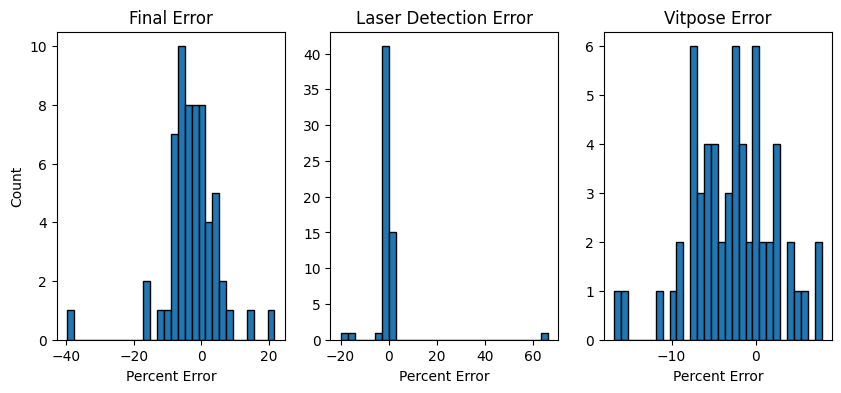

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs = axs.flatten()

axs[0].hist(errors, bins=30, edgecolor='black')
axs[0].set_xlabel("Percent Error")
axs[0].set_ylabel("Count")
axs[0].set_title("Final Error")

axs[1].hist(laser_errors, bins=30, edgecolor='black')
axs[1].set_xlabel("Percent Error")
axs[1].set_title("Laser Detection Error")

axs[2].hist(body_errors, bins=30, edgecolor='black')
axs[2].set_xlabel("Percent Error")
axs[2].set_title("Vitpose Error")

plt.show()

In [70]:
print("mean:", np.mean(errors))
print("median:", np.median(errors))
print("std:", np.std(errors))
print("min:", np.min(errors), "max:", np.max(errors))

mean: -2.753333333333333
median: -2.8500000000000005
std: 7.819536786508237
min: -39.7 max: 21.7


In [71]:
print("mean:", np.mean(laser_errors))
print("median:", np.median(laser_errors))
print("std:", np.std(laser_errors))
print("min:", np.min(laser_errors), "max:", np.max(laser_errors))

mean: 0.4450000000000001
median: 0.0
std: 9.19406375512664
min: -19.900000000000002 max: 66.4


In [72]:
print("mean:", np.mean(body_errors))
print("median:", np.median(body_errors))
print("std:", np.std(body_errors))
print("min:", np.min(body_errors), "max:", np.max(body_errors))

mean: -2.85
median: -2.45
std: 4.9309397346415285
min: -16.8 max: 7.8


In [45]:
pd.DataFrame(errors).describe()

,0
count,60.000000
mean,5.683333
std,6.086305
min,0.300000
25%,2.200000
50%,4.150000
75%,7.050000
max,39.700000


In [46]:
import matplotlib.pyplot as plt

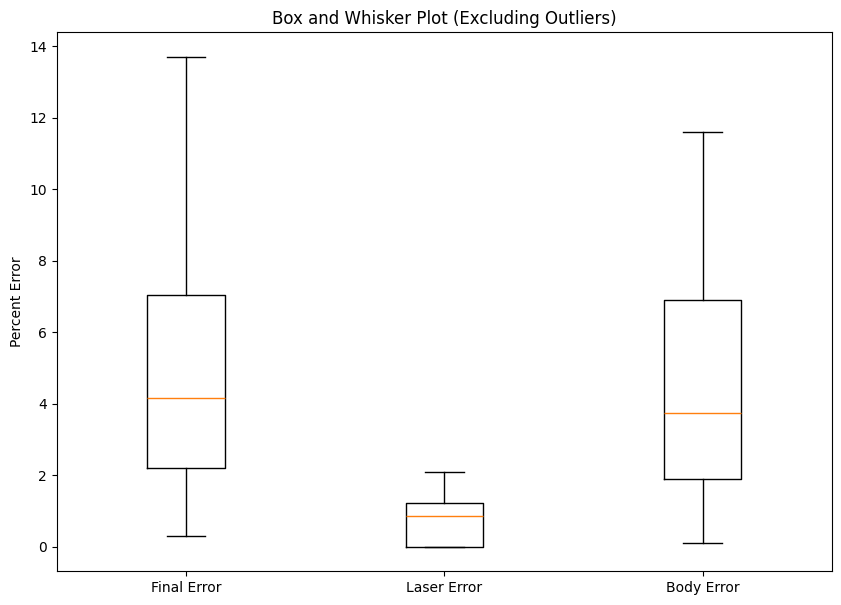

In [47]:
data = [errors, laser_errors, body_errors]
fig = plt.figure(figsize =(10, 7))
plt.boxplot(data, showfliers=False)
plt.ylabel("Percent Error")
plt.xticks([1, 2, 3], ['Final Error', 'Laser Error', 'Body Error'])
plt.title('Box and Whisker Plot (Excluding Outliers)')
plt.show()

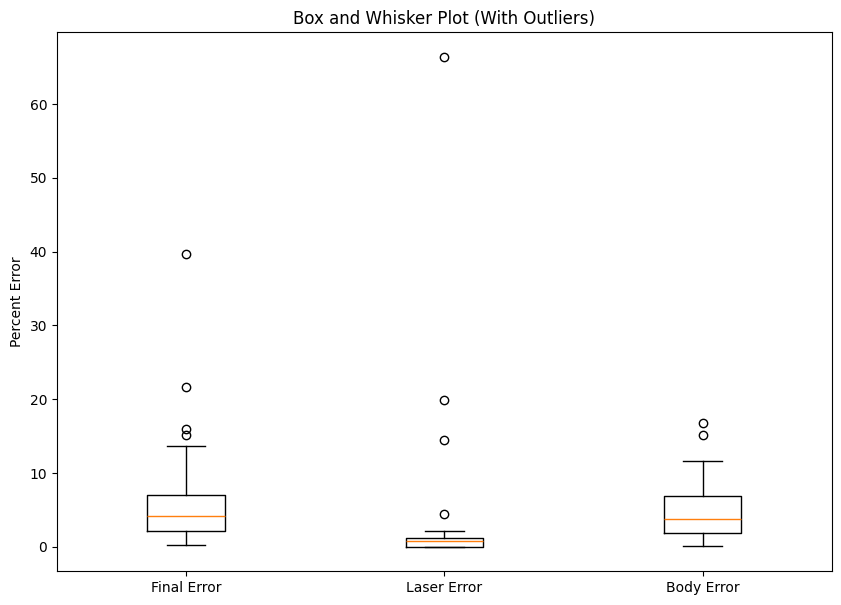

In [48]:
data = [errors, laser_errors, body_errors]
fig = plt.figure(figsize =(10, 7))
plt.boxplot(data, showfliers=True)
plt.ylabel("Percent Error")
plt.xticks([1, 2, 3], ['Final Error', 'Laser Error', 'Body Error'])
plt.title('Box and Whisker Plot (With Outliers)')
plt.show()

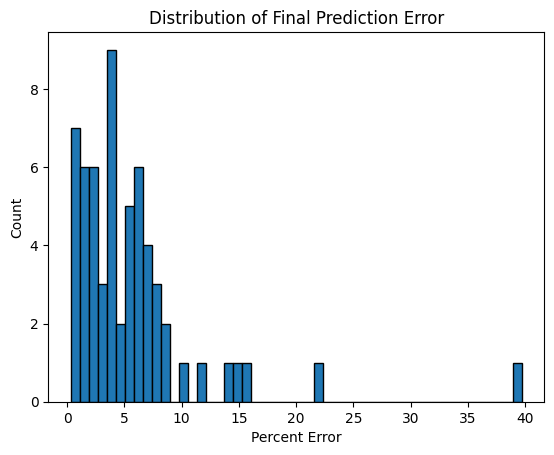

In [49]:
plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel("Percent Error")
plt.ylabel("Count")
plt.title("Distribution of Final Prediction Error")
plt.show()

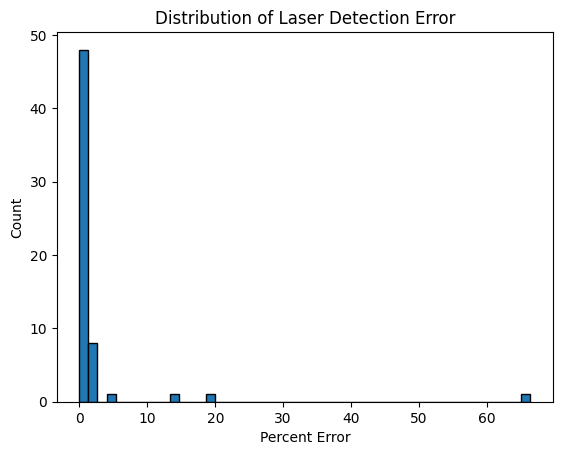

In [50]:
plt.hist(laser_errors, bins=50, edgecolor='black')
plt.xlabel("Percent Error")
plt.ylabel("Count")
plt.title("Distribution of Laser Detection Error")
plt.show()

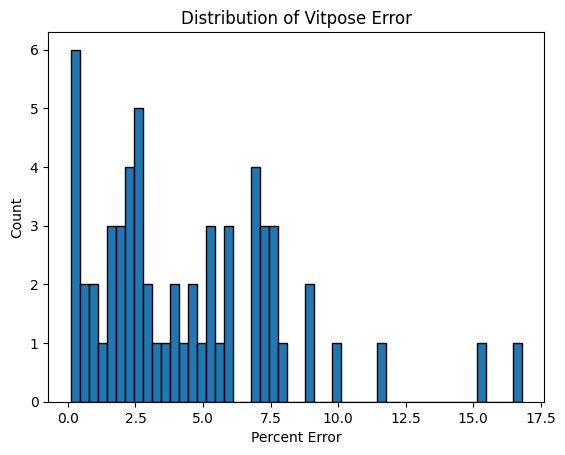

In [51]:
plt.hist(body_errors, bins=50, edgecolor='black')
plt.xlabel("Percent Error")
plt.ylabel("Count")
plt.title("Distribution of Vitpose Error")
plt.show()

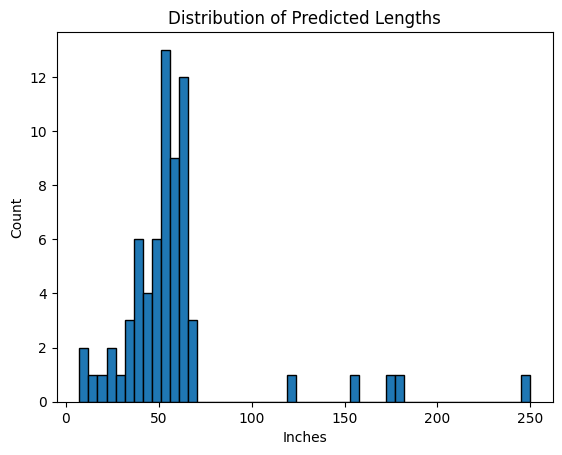

In [28]:
plt.hist(predicted_lengths, bins=50, edgecolor='black')
plt.xlabel("Inches")
plt.ylabel("Count")
plt.title("Distribution of Predicted Lengths")
plt.show()

In [45]:
print("mean:", np.mean(predicted_lengths))
print("median:", np.median(predicted_lengths))
print("std:", np.std(predicted_lengths))
print("min:", np.min(predicted_lengths), "max:", np.max(predicted_lengths))

mean: 59.09186573194976
median: 54.36100628930817
std: 35.72754231222906
min: 7.265899059681443 max: 250.0171875


In [29]:
fail_ims

['21-Oct-2015-232.JPG',
 '29-Jan-2016-704.JPG',
 '30-Nov-2015-297.JPG',
 '23-Nov-2015-470.JPG']

In [74]:
def draw_dots(points, ax, color):
    ax.scatter(points[:, 0], points[:, 1], color=color, s=25, edgecolor='black')

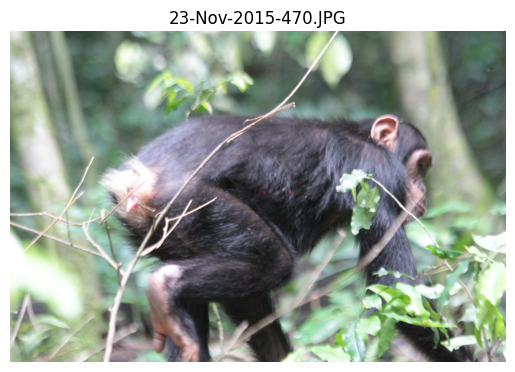

In [35]:
idx = 3
image_name = fail_ims[idx]
info = image_data[image_name]

image_path = os.path.join(image_folder, image_name)
# load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

# extract coordinates
laser_points = np.array(info['laser_points'])
body_points = np.array(info['shoulder_rump'])

# plot image
plt.imshow(img)

# draw_dots(laser_points, plt, "skyblue")
# draw_dots(body_points, plt, "yellow")
plt.title(f"{image_name}")
plt.axis('off')

plt.show()

In [44]:
if "KCP_test_im".startswith("KCP"):
    print("yup")

yup
